### Generating Adversarial Inputs with Foolbox

Foolbox facilitates adversarial exploration of trained models. In this example, we'll use Keras built-in ResNet50 CNN model and ResNet50's weights for use with ImageNet. Foolbox has a `KerasModel` method that creates a Foolbox model given a Keras model, the code below instantiates the ResNet50 model with ImageNet weights, define a prescribed normalization procedure for the images going into the model, and bound our input values to 8-bit unsigned values. We then get a sample of images from one of the sample sets bundled with Foolbox, imagenet in our case. Foolbox also provides samples of mnist, cifar10, cifar100, and fashionMNIST.

In [12]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.attacks import FGSM
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
import keras_utils
import matplotlib.pyplot as plt

keras.backend.set_learning_phase(0)
kmodel = keras.applications.resnet50.ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)
images, labels = foolbox.utils.samples(batchsize=13)


#### Generating an adversarial input targeted to another class

That's it! We're ready to start creating adversarial inputs. First, we will pursue an adversarial image derived from an image in the sample space which will cause the model to classify it as another class. We'll go with the Foolbox imagenet image at index 9, which happens to be a bottle cap. We'll target our adversary attack to force a misclassification of an egyptian cat. The following code does so by specifying a `TargetClass` criterion and instantiating a LBFGSAttack object based on the criterion and the foolbox `KerasModel` we created above. More info on the L-BFGS Attack can be found [here](https://arxiv.org/pdf/1312.6199.pdf).

In [7]:
criterion = foolbox.criteria.TargetClass(285)
index = 9
image = images[index]
label = labels[index]
attack    = foolbox.attacks.LBFGSAttack(fmodel, criterion=criterion)

Now we can use the `attack` object to generate an adversarial example, to do so we provide the bottle cap image and its label.

In [13]:
adversarial = attack(image[:, :, ::-1], label)

#### Results

Let's verify what the model predicts the original image to be. In the code below, we create an RGB version of the input image, per the Keras model's requirements, then send a copy of the image for proprocessing and prediction using the model. We then use the Keras built-in `decode_predictions` utility in order to get the top 5 prediction numbers, names, and probability.

In [9]:
image_rgb = image[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(image_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

Top 5 predictions (adversarial:  [[('n02877765', 'bottlecap', 0.999997), ('n04019541', 'puck', 9.67901e-07), ('n02823428', 'beer_bottle', 4.9048214e-07), ('n03929660', 'pick', 4.2090298e-07), ('n04557648', 'water_bottle', 1.7790839e-07)]]


As expected, the image is classified as a bottle cap. In the code below, we do a similar procedure only for the adversarial image that was created above. 

In [14]:
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
adv_preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial: ", decode_predictions(adv_preds, top=5))

Top 5 predictions (adversarial:  [[('n02124075', 'Egyptian_cat', 0.33895558), ('n02123045', 'tabby', 0.07437768), ('n02877765', 'bottlecap', 0.061316747), ('n04599235', 'wool', 0.03492084), ('n04423845', 'thimble', 0.034246325)]]


So, we were able to confuse the classifier with this image to the extent it gave 0.33 probability to the image being a bottle cap. Anomaly detection would hopefully pick this up, kicking off model retraining or at least an alert.

Now let's see what the original and adversarial images look like, along with the difference between them.

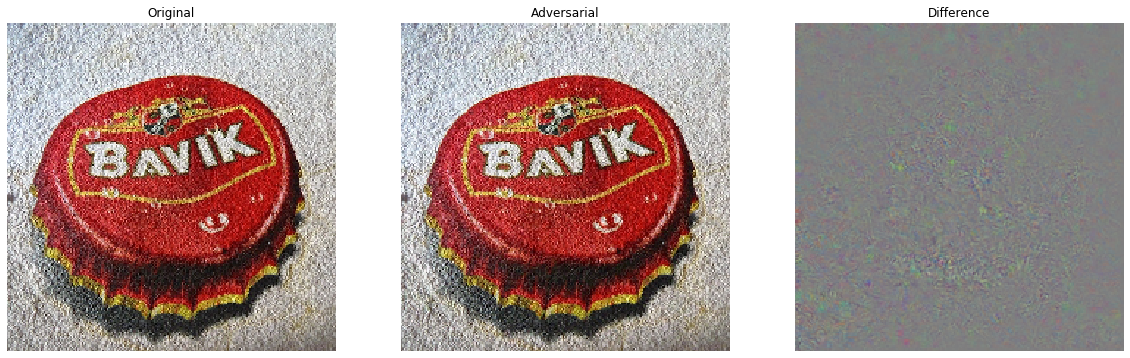

In [15]:
plt.rcParams["figure.figsize"] = (20,10)

plt.figure()
plt.subplot(1, 3, 1)

plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

The adversarial image surely looks more like a bottle cap than an egyptian cat! Without the difference image above, it's difficult to tell anything has changed between the original and adversary.

#### Generating an untargeted adversarial input

On the proactive side of model training, we may want to generate a number of advserial inputs with the intent of determining just how disruptive adversarial attacks could be. In the code below, we create a new attack without the criterion defined earlier.


In [18]:
untargeted_attack    = foolbox.attacks.LBFGSAttack(fmodel)
untargeted_adversarial = untargeted_attack(image[:, :, ::-1], label)

Now let's see how the model performs against this adversarial image:

In [19]:
untargeted_adversarial_rgb = untargeted_adversarial[np.newaxis, :, :, ::-1]
untargeted_adv_preds = kmodel.predict(preprocess_input(untargeted_adversarial_rgb.copy()))
print("Top 5 predictions (untargeted adversarial: ", decode_predictions(untargeted_adv_preds, top=5))

Top 5 predictions (untargeted adversarial:  [[('n03223299', 'doormat', 0.8534778), ('n02877765', 'bottlecap', 0.11391223), ('n03998194', 'prayer_rug', 0.009991859), ('n04599235', 'wool', 0.006249747), ('n03871628', 'packet', 0.0024679608)]]


We've convinced the model the image is of a door mat with much higher probability than the targeted case. This is less likely to set off anomaly detection, and would be a candidate for an input image to retrain the model with.

Finally, here's the original, untargeted adversarial, and their difference:

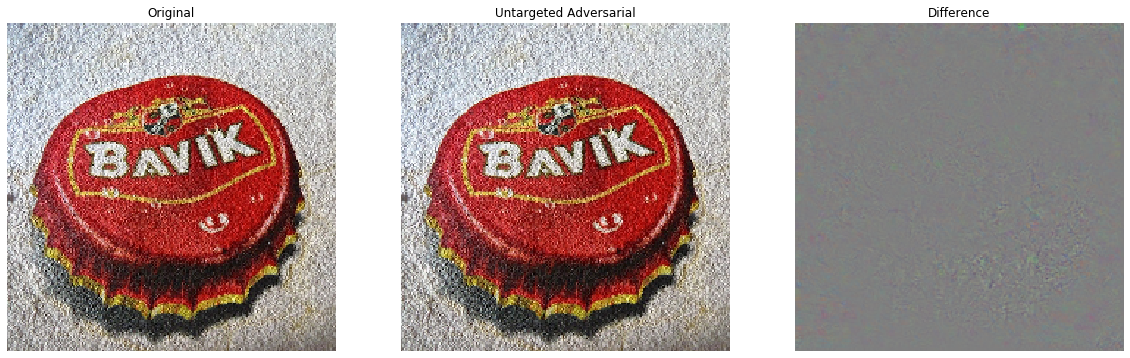

In [20]:
plt.rcParams["figure.figsize"] = (20,10)

plt.figure()
plt.subplot(1, 3, 1)

plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Untargeted Adversarial')
plt.imshow(untargeted_adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = untargeted_adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()